In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle

from matplotlib.gridspec import GridSpec
from llm_deliberation.utils import bootstrap_statistic_df, jaccard
from scipy.stats import mannwhitneyu

from pyprojroot import here
from mpl_lego.labels import bold_text, add_significance_bracket_inplot, apply_subplot_labels
from mpl_lego.style import use_latex_style

In [2]:
use_latex_style()

In [3]:
with open(here('data/analysis/exp1_sync_h2h.pkl'), 'rb') as file:
    exp1 = pickle.load(file)

with open(here('data/analysis/exp5_sync_h2h.pkl'), 'rb') as file:
    exp2 = pickle.load(file)

with open(here('data/analysis/exp6_sync_h2h.pkl'), 'rb') as file:
    exp3 = pickle.load(file)

In [4]:
exp1_expl = exp1.explode(['Agent_1_verdicts', 'Agent_2_verdicts', 'Agent_1_values', 'Agent_2_values']).reset_index()
exp2_expl = exp2.explode(['Agent_1_verdicts', 'Agent_2_verdicts', 'Agent_1_values', 'Agent_2_values']).reset_index()
exp3_expl = exp3.explode(['Agent_1_verdicts', 'Agent_2_verdicts', 'Agent_1_values', 'Agent_2_values']).reset_index()

In [5]:
def bootstrap_vals(exploded, value):
    return bootstrap_statistic_df(
        df=exploded,
        statistic_func=lambda df: (
            df['Agent_1_values'].explode().value_counts()[value]
            - df['Agent_2_values'].explode().value_counts()[value]
        ) / df.shape[0],
        confidence_level=0.95,
        n_bootstrap=1000
    )

In [6]:
exp1_agent1_value_props = (exp1_expl['Agent_1_values'].explode().value_counts() / exp1_expl.shape[0]).sort_index()
exp1_agent2_value_props = (exp1_expl['Agent_2_values'].explode().value_counts() / exp1_expl.shape[0]).sort_index()

exp2_agent1_value_props = (exp2_expl['Agent_1_values'].explode().value_counts() / exp2_expl.shape[0]).sort_index()
exp2_agent2_value_props = (exp2_expl['Agent_2_values'].explode().value_counts() / exp2_expl.shape[0]).sort_index()

exp3_agent1_value_props = (exp3_expl['Agent_1_values'].explode().value_counts() / exp3_expl.shape[0]).sort_index()
exp3_agent2_value_props = (exp3_expl['Agent_2_values'].explode().value_counts() / exp3_expl.shape[0]).sort_index()

In [7]:
exp1_agent1_vals = (exp1_agent1_value_props - exp1_agent2_value_props).sort_values(ascending=False).head(5).index
exp1_agent2_vals = (exp1_agent1_value_props - exp1_agent2_value_props).sort_values(ascending=True).head(5).index

exp2_agent1_vals = (exp2_agent1_value_props - exp2_agent2_value_props).sort_values(ascending=False).head(5).index
exp2_agent2_vals = (exp2_agent1_value_props - exp2_agent2_value_props).sort_values(ascending=True).head(5).index

exp3_agent1_vals = (exp3_agent1_value_props - exp3_agent2_value_props).sort_values(ascending=False).head(5).index
exp3_agent2_vals = (exp3_agent1_value_props - exp3_agent2_value_props).sort_values(ascending=True).head(5).index

In [8]:
exp1_diffs = (exp1_agent1_value_props.sort_index() - exp1_agent2_value_props.sort_index()).sort_values().dropna()
exp2_diffs = (exp2_agent1_value_props.sort_index() - exp2_agent2_value_props.sort_index()).sort_values().dropna()
exp3_diffs = (exp3_agent1_value_props.sort_index() - exp3_agent2_value_props.sort_index()).sort_values().dropna()

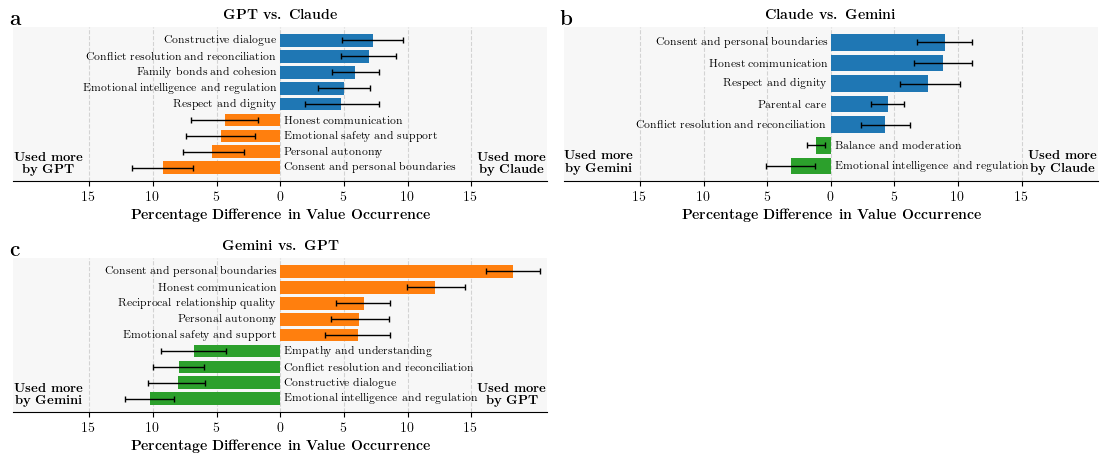

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 5))
plt.subplots_adjust(hspace=0.5, wspace=0.03)

N_VIEW = 5
PAD = 3
colors = [('C0', 'C1'), ('C0', 'C2'), ('C1', 'C2')]

# match each diffs with its exploded DF used by bootstrap
explodeds = [exp1_expl, exp2_expl, exp3_expl]

def ci_err(res):
    # prefer explicit errs if present; fall back to ci bounds
    if "lower_err" in res and "upper_err" in res:
        lo = float(res["lower_err"])
        hi = float(res["upper_err"])
    else:
        m  = float(res["mean"])
        lo = m - float(res["ci_lower"])
        hi = float(res["ci_upper"]) - m
    # return in percentage points to match 100*diffs
    return 100*lo, 100*hi

def crosses_zero(res):
    # est and asymmetric errs in percentage points
    est = 100 * float(res["mean"])
    if "lower_err" in res and "upper_err" in res:
        lo = 100 * float(res["lower_err"])
        hi = 100 * float(res["upper_err"])
    else:
        lo = 100 * (float(res["mean"]) - float(res["ci_lower"]))
        hi = 100 * (float(res["ci_upper"]) - float(res["mean"]))
    return (est - lo) <= 0 <= (est + hi), est, lo, hi

axes_list = axes.ravel()

for ax, diffs, exploded, (c1, c2) in zip(
    axes_list, [exp1_diffs, exp2_diffs, exp3_diffs], explodeds, colors
):
    top = diffs.tail(N_VIEW)
    bot = diffs.head(N_VIEW)

    # collect kept items (value, est, [lo, hi])
    keep_bot = []
    for v in bot.index:
        cz, est, lo, hi = crosses_zero(bootstrap_vals(exploded, v))
        if not cz:
            keep_bot.append((v, est, lo, hi))

    keep_top = []
    for v in top.index:
        cz, est, lo, hi = crosses_zero(bootstrap_vals(exploded, v))
        if not cz:
            keep_top.append((v, est, lo, hi))

    # pack y positions: bottom first (low y), then top above
    y_bot = list(range(len(keep_bot)))
    y_top = list(range(len(keep_bot), len(keep_bot) + len(keep_top)))

    # plot bars with xerr
    if keep_bot:
        ests = [e for _, e, _, _ in keep_bot]
        errs = np.array([[lo for _, _, lo, _ in keep_bot],
                         [hi for _, _, _, hi in keep_bot]])
        ax.barh(y_bot, ests, color=c2, xerr=errs,
                error_kw=dict(lw=1, capsize=2, zorder=2))
    if keep_top:
        ests = [e for _, e, _, _ in keep_top]
        errs = np.array([[lo for _, _, lo, _ in keep_top],
                         [hi for _, _, _, hi in keep_top]])
        ax.barh(y_top, ests, color=c1, xerr=errs,
                error_kw=dict(lw=1, capsize=2, zorder=2))

    # styling (keep bottom spine & x-ticks; y-ticks off; grid under)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.xaxis.grid(True, linestyle="--", alpha=0.5)
    ax.set_axisbelow(True)
    ax.set_yticks([])

    # labels anchored at x=0, away from bars (other side)
    for y, (lab, est, *_ ) in zip(y_top, keep_top):
        ax.annotate(lab, xy=(0, y), xycoords="data",
                    xytext=(-PAD, 0), textcoords="offset points",
                    fontsize=8, ha="right", va="center", zorder=3)
    for y, (lab, est, *_ ) in zip(y_bot, keep_bot):
        ax.annotate(lab, xy=(0, y), xycoords="data",
                    xytext=(PAD, 0), textcoords="offset points",
                    fontsize=8, ha="left", va="center", zorder=3)

    ax.set_xlim(-21, 21)
    ax.set_xticks([-15, -10, -5, 0, 5, 10, 15])
    ax.set_xticklabels(['15', '10', '5', '0', '5', '10', '15'])
    ax.set_facecolor('0.97')
    ax.set_xlabel(bold_text('Percentage Difference in Value Occurrence'), fontsize=10)

axes_list[0].annotate(bold_text('Used more\nby Claude'), xy=(18.2, 0.3), fontsize=9, ha="center", va="center", zorder=3)
axes_list[0].annotate(bold_text('Used more\nby GPT'), xy=(-18.2, 0.3), fontsize=9, ha="center", va="center", zorder=3)
axes_list[1].annotate(bold_text('Used more\nby Claude'), xy=(18.2, 0.2), fontsize=9, ha="center", va="center", zorder=3)
axes_list[1].annotate(bold_text('Used more\nby Gemini'), xy=(-18.2, 0.2), fontsize=9, ha="center", va="center", zorder=3)
axes_list[2].annotate(bold_text('Used more\nby GPT'), xy=(18.2, 0.3), fontsize=9, ha="center", va="center", zorder=3)
axes_list[2].annotate(bold_text('Used more\nby Gemini'), xy=(-18.2, 0.3), fontsize=9, ha="center", va="center", zorder=3)

axes_list[0].set_title(bold_text('GPT vs. Claude'), fontsize=10)
axes_list[1].set_title(bold_text('Claude vs. Gemini'), fontsize=10)
axes_list[2].set_title(bold_text('Gemini vs. GPT'), fontsize=10)
axes_list[-1].axis('off')

apply_subplot_labels(axes_list[:-1], bold=True, x=0.005, y=1.05, size=15)
plt.savefig('fig_value_occurrences.pdf', bbox_inches='tight')

In [9]:
def bootstrap_inherited(exp, agent, value):
    exp_agent_cov = exp[exp[f'{agent}_verdicts'].apply(lambda x: len(set(x)) > 1)]
    if agent == 'Agent_1':
        other = 'Agent_2'
    else:
        other = 'Agent_1'

    return bootstrap_statistic_df(
        df=exp_agent_cov,
        statistic_func=lambda df: df[['Agent_1_values', 'Agent_2_values']].apply(
            lambda x: 
                (x[f'{agent}_values'][-1] - x[f'{agent}_values'][0]).intersection(x[f'{other}_values'][0]), axis=1
            ).explode().value_counts().get(value, 0) / df.shape[0],
        confidence_level=0.95,
        n_bootstrap=1000
    )

In [10]:
exp1_agent1_cov = exp1['Agent_1_verdicts'].apply(lambda x: len(set(x)) > 1)
exp1_agent2_cov = exp1['Agent_2_verdicts'].apply(lambda x: len(set(x)) > 1)

exp2_agent1_cov = exp2['Agent_1_verdicts'].apply(lambda x: len(set(x)) > 1)
exp2_agent2_cov = exp2['Agent_2_verdicts'].apply(lambda x: len(set(x)) > 1)

exp3_agent1_cov = exp3['Agent_1_verdicts'].apply(lambda x: len(set(x)) > 1)
exp3_agent2_cov = exp3['Agent_2_verdicts'].apply(lambda x: len(set(x)) > 1)

exp1_agent1_inherited = exp1[exp1_agent1_cov][['Agent_1_values', 'Agent_2_values']].apply(
    lambda x: 
        (x['Agent_1_values'][-1] - x['Agent_1_values'][0]).intersection(x['Agent_2_values'][0]), axis=1
).explode().value_counts() / exp1_agent1_cov.sum()
exp1_agent2_inherited = exp1[exp1_agent2_cov][['Agent_1_values', 'Agent_2_values']].apply(
    lambda x: 
        (x['Agent_2_values'][-1] - x['Agent_2_values'][0]).intersection(x['Agent_1_values'][0]), axis=1
).explode().value_counts() / exp1_agent2_cov.sum()

exp2_agent1_inherited = exp2[exp2_agent1_cov][['Agent_1_values', 'Agent_2_values']].apply(
    lambda x: 
        (x['Agent_1_values'][-1] - x['Agent_1_values'][0]).intersection(x['Agent_2_values'][0]), axis=1
).explode().value_counts() / exp2_agent1_cov.sum()
exp2_agent2_inherited = exp2[exp2_agent2_cov][['Agent_1_values', 'Agent_2_values']].apply(
    lambda x: 
        (x['Agent_2_values'][-1] - x['Agent_2_values'][0]).intersection(x['Agent_1_values'][0]), axis=1
).explode().value_counts() / exp2_agent2_cov.sum()

exp3_agent1_inherited = exp3[exp3_agent1_cov][['Agent_1_values', 'Agent_2_values']].apply(
    lambda x: 
        (x['Agent_1_values'][-1] - x['Agent_1_values'][0]).intersection(x['Agent_2_values'][0]), axis=1
).explode().value_counts() / exp3_agent1_cov.sum()
exp3_agent2_inherited = exp3[exp3_agent2_cov][['Agent_1_values', 'Agent_2_values']].apply(
    lambda x: 
        (x['Agent_2_values'][-1] - x['Agent_2_values'][0]).intersection(x['Agent_1_values'][0]), axis=1
).explode().value_counts() / exp3_agent2_cov.sum()

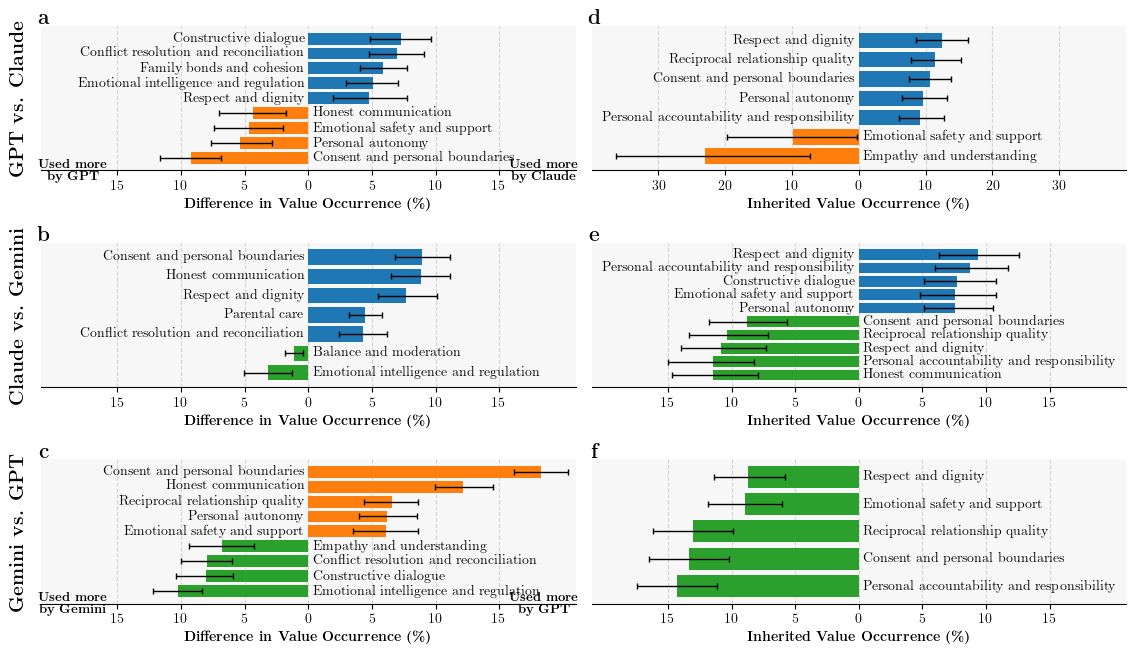

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(14, 7.5))
plt.subplots_adjust(hspace=0.5, wspace=0.03)

N_VIEW = 5
PAD = 3
colors = [('C0', 'C1'), ('C0', 'C2'), ('C1', 'C2')]

# match each diffs with its exploded DF used by bootstrap
explodeds = [exp1_expl, exp2_expl, exp3_expl]

def ci_err(res):
    # prefer explicit errs if present; fall back to ci bounds
    if "lower_err" in res and "upper_err" in res:
        lo = float(res["lower_err"])
        hi = float(res["upper_err"])
    else:
        m  = float(res["mean"])
        lo = m - float(res["ci_lower"])
        hi = float(res["ci_upper"]) - m
    # return in percentage points to match 100*diffs
    return 100*lo, 100*hi

def crosses_zero(res):
    # est and asymmetric errs in percentage points
    est = 100 * float(res["mean"])
    if "lower_err" in res and "upper_err" in res:
        lo = 100 * float(res["lower_err"])
        hi = 100 * float(res["upper_err"])
    else:
        lo = 100 * (float(res["mean"]) - float(res["ci_lower"]))
        hi = 100 * (float(res["ci_upper"]) - float(res["mean"]))
    return (est - lo) <= 0 <= (est + hi), est, lo, hi

axes_list = axes[:, 0].ravel()

for ax, diffs, exploded, (c1, c2) in zip(
    axes_list, [exp1_diffs, exp2_diffs, exp3_diffs], explodeds, colors
):
    top = diffs.tail(N_VIEW)
    bot = diffs.head(N_VIEW)

    # collect kept items (value, est, [lo, hi])
    keep_bot = []
    for v in bot.index:
        cz, est, lo, hi = crosses_zero(bootstrap_vals(exploded, v))
        if not cz:
            keep_bot.append((v, est, lo, hi))

    keep_top = []
    for v in top.index:
        cz, est, lo, hi = crosses_zero(bootstrap_vals(exploded, v))
        if not cz:
            keep_top.append((v, est, lo, hi))

    # pack y positions: bottom first (low y), then top above
    y_bot = list(range(len(keep_bot)))
    y_top = list(range(len(keep_bot), len(keep_bot) + len(keep_top)))

    # plot bars with xerr
    if keep_bot:
        ests = [e for _, e, _, _ in keep_bot]
        errs = np.array([[lo for _, _, lo, _ in keep_bot],
                         [hi for _, _, _, hi in keep_bot]])
        ax.barh(y_bot, ests, color=c2, xerr=errs,
                error_kw=dict(lw=1, capsize=2, zorder=2))
    if keep_top:
        ests = [e for _, e, _, _ in keep_top]
        errs = np.array([[lo for _, _, lo, _ in keep_top],
                         [hi for _, _, _, hi in keep_top]])
        ax.barh(y_top, ests, color=c1, xerr=errs,
                error_kw=dict(lw=1, capsize=2, zorder=2))

    # styling (keep bottom spine & x-ticks; y-ticks off; grid under)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.xaxis.grid(True, linestyle="--", alpha=0.5)
    ax.set_axisbelow(True)
    ax.set_yticks([])

    # labels anchored at x=0, away from bars (other side)
    for y, (lab, est, *_ ) in zip(y_top, keep_top):
        ax.annotate(lab, xy=(0, y), xycoords="data",
                    xytext=(-PAD, 0), textcoords="offset points",
                    fontsize=10, ha="right", va="center", zorder=3)
    for y, (lab, est, *_ ) in zip(y_bot, keep_bot):
        ax.annotate(lab, xy=(0, y), xycoords="data",
                    xytext=(PAD, 0), textcoords="offset points",
                    fontsize=10, ha="left", va="center", zorder=3)

    ax.set_xlim(-21, 21)
    ax.set_xticks([-15, -10, -5, 0, 5, 10, 15])
    ax.set_xticklabels(['15', '10', '5', '0', '5', '10', '15'])
    ax.set_facecolor('0.97')
    ax.set_xlabel(bold_text('Difference in Value Occurrence (\%)'), fontsize=10)

axes_list[0].annotate(bold_text('Used more\nby Claude'), xy=(18.5, -0.85), fontsize=9, ha="center", va="center", zorder=3, transform=fig.transFigure)
axes_list[0].annotate(bold_text('Used more\nby GPT'), xy=(-18.5, -0.85), fontsize=9, ha="center", va="center", zorder=3)
axes_list[1].annotate(bold_text('Used more\nby Claude'), xy=(18.5, -0.85), fontsize=9, ha="center", va="center", zorder=3)
axes_list[1].annotate(bold_text('Used more\nby Gemini'), xy=(-18.5, -0.85), fontsize=9, ha="center", va="center", zorder=3)
axes_list[2].annotate(bold_text('Used more\nby GPT'), xy=(18.5, -0.85), fontsize=9, ha="center", va="center", zorder=3)
axes_list[2].annotate(bold_text('Used more\nby Gemini'), xy=(-18.5, -0.85), fontsize=9, ha="center", va="center", zorder=3)

axes_list[0].set_ylabel(bold_text('GPT vs. Claude'), fontsize=14, labelpad=10)
axes_list[1].set_ylabel(bold_text('Claude vs. Gemini'), fontsize=14, labelpad=10)
axes_list[2].set_ylabel(bold_text('Gemini vs. GPT'), fontsize=14, labelpad=10)

# ----- RIGHT COLUMN: "Inherited" plots (top-K per agent, mirror layout) -----
TOPK = 5  # make this your knob

# ----- RIGHT COLUMN: Inherited plots with zero-crossing removal (no gaps, preserve order) -----
axes_right = axes[:, 1].ravel()
right_specs = [
    (axes_right[0], exp1, exp1_agent1_inherited, exp1_agent2_inherited, colors[0]),
    (axes_right[1], exp2, exp2_agent1_inherited, exp2_agent2_inherited, colors[1]),
    (axes_right[2], exp3, exp3_agent1_inherited, exp3_agent2_inherited, colors[2]),
]

def crosses_zero_plotted(exp, agent, value, mirror=False):
    res = bootstrap_inherited(exp, agent, value)
    lo, hi = ci_err(res)                   # already in percentage points
    est = 100 * float(res["mean"])         # percentage
    p_est = -est if mirror else est        # sign as plotted
    return (p_est - lo) <= 0 <= (p_est + hi), p_est, lo, hi

for ax, exp, s_agent1, s_agent2, (c1, c2) in right_specs:
    k1 = s_agent1.nlargest(TOPK)  # Agent_1 (right, positive)
    k2 = s_agent2.nlargest(TOPK)  # Agent_2 (left, mirrored)

    keep_left = []   # (label, plotted_est, lo, hi) for Agent_2 (mirrored negative)
    for v in k2.index:
        cz, p_est, lo, hi = crosses_zero_plotted(exp, 'Agent_2', v, mirror=True)
        if not cz:
            keep_left.append((v, p_est, lo, hi))

    keep_right = []  # for Agent_1 (positive)
    for v in k1.index:
        cz, p_est, lo, hi = crosses_zero_plotted(exp, 'Agent_1', v, mirror=False)
        if not cz:
            keep_right.append((v, p_est, lo, hi))

    # contiguous y positions without gaps; keep original order within each group
    y_left  = list(range(len(keep_left)))
    y_right = list(range(len(keep_left), len(keep_left) + len(keep_right)))

    # draw bars + error bars
    if keep_left:
        ests = [e for _, e, _, _ in keep_left]
        errs = np.array([[lo for _, _, lo, _ in keep_left],
                         [hi for _, _, _, hi in keep_left]])
        ax.barh(y_left, ests, color=c2, xerr=errs,
                error_kw=dict(lw=1, capsize=2, zorder=2))
# Replace the RIGHT (Agent_1) drawing + labels inside the loop with this to put bigger values higher up:
    if keep_right:
        kr = keep_right[::-1]  # smallest -> largest from bottom to top, so largest ends up highest
        ests = [e for _, e, _, _ in kr]
        errs = np.array([[lo for _, _, lo, _ in kr],
                        [hi for _, _, _, hi in kr]])
        ax.barh(y_right, ests, color=c1, xerr=errs,
                error_kw=dict(lw=1, capsize=2, zorder=2))

    # style to match left column
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.xaxis.grid(True, linestyle="--", alpha=0.5)
    ax.set_axisbelow(True)
    ax.set_yticks([])

    # labels anchored at x=0 on the "other" side of the bar
    # positive (right) -> label starts at 0 (left-aligned, nudged right)
    # labels anchored at x=0 on the opposite side
    for y, (lab, *_ ) in zip(y_right, kr if keep_right else []):
        ax.annotate(lab, xy=(0, y), xycoords="data",
                    xytext=(-PAD, 0), textcoords="offset points",
                    fontsize=10, ha="right", va="center", zorder=3)
    for y, (lab, *_ ) in zip(y_left, keep_left):
        ax.annotate(lab, xy=(0, y), xycoords="data",
                    xytext=(PAD, 0), textcoords="offset points",
                    fontsize=10, ha="left", va="center", zorder=3)

    ax.set_xlim(-21, 21)
    ax.set_xticks([-15, -10, -5, 0, 5, 10, 15])
    ax.set_xticklabels(['15', '10', '5', '0', '5', '10', '15'])
    ax.set_facecolor('0.97')
    ax.set_xlabel(bold_text('Inherited Value Occurrence (\%)'), fontsize=10)

axes[0, 1].set_xticks([-30, -20, -10, 0, 10, 20, 30])
axes[0, 1].set_xticklabels(['30', '20', '10', '0', '10', '20', '30'])
axes[0, 1].set_xlim([-40, 40])
apply_subplot_labels([axes[0, 0], axes[1, 0], axes[2, 0], axes[0, 1], axes[1, 1], axes[2, 1]], bold=True, x=0.005, y=1.05, size=15)
plt.savefig('fig_value_occurrences.pdf', bbox_inches='tight')

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 5))
plt.subplots_adjust(hspace=0.5, wspace=0.03)

N_VIEW = 5
PAD = 3
colors = [('C0', 'C1'), ('C0', 'C2'), ('C1', 'C2')]

# match each diffs with its exploded DF used by bootstrap
explodeds = [exp1_expl, exp2_expl, exp3_expl]

def ci_err(res):
    # prefer explicit errs if present; fall back to ci bounds
    if "lower_err" in res and "upper_err" in res:
        lo = float(res["lower_err"])
        hi = float(res["upper_err"])
    else:
        m  = float(res["mean"])
        lo = m - float(res["ci_lower"])
        hi = float(res["ci_upper"]) - m
    # return in percentage points to match 100*diffs
    return 100*lo, 100*hi

def crosses_zero(res):
    # est and asymmetric errs in percentage points
    est = 100 * float(res["mean"])
    if "lower_err" in res and "upper_err" in res:
        lo = 100 * float(res["lower_err"])
        hi = 100 * float(res["upper_err"])
    else:
        lo = 100 * (float(res["mean"]) - float(res["ci_lower"]))
        hi = 100 * (float(res["ci_upper"]) - float(res["mean"]))
    return (est - lo) <= 0 <= (est + hi), est, lo, hi

axes_list = axes.ravel()

for ax, diffs, exploded, (c1, c2) in zip(
    axes_list, [exp1_diffs, exp2_diffs, exp3_diffs], explodeds, colors
):
    top = diffs.tail(N_VIEW)
    bot = diffs.head(N_VIEW)

    # collect kept items (value, est, [lo, hi])
    keep_bot = []
    for v in bot.index:
        cz, est, lo, hi = crosses_zero(bootstrap_vals(exploded, v))
        if not cz:
            keep_bot.append((v, est, lo, hi))

    keep_top = []
    for v in top.index:
        cz, est, lo, hi = crosses_zero(bootstrap_vals(exploded, v))
        if not cz:
            keep_top.append((v, est, lo, hi))

    # pack y positions: bottom first (low y), then top above
    y_bot = list(range(len(keep_bot)))
    y_top = list(range(len(keep_bot), len(keep_bot) + len(keep_top)))

    # plot bars with xerr
    if keep_bot:
        ests = [e for _, e, _, _ in keep_bot]
        errs = np.array([[lo for _, _, lo, _ in keep_bot],
                         [hi for _, _, _, hi in keep_bot]])
        ax.barh(y_bot, ests, color=c2, xerr=errs,
                error_kw=dict(lw=1, capsize=2, zorder=2))
    if keep_top:
        ests = [e for _, e, _, _ in keep_top]
        errs = np.array([[lo for _, _, lo, _ in keep_top],
                         [hi for _, _, _, hi in keep_top]])
        ax.barh(y_top, ests, color=c1, xerr=errs,
                error_kw=dict(lw=1, capsize=2, zorder=2))

    # styling (keep bottom spine & x-ticks; y-ticks off; grid under)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.xaxis.grid(True, linestyle="--", alpha=0.5)
    ax.set_axisbelow(True)
    ax.set_yticks([])

    # labels anchored at x=0, away from bars (other side)
    for y, (lab, est, *_ ) in zip(y_top, keep_top):
        ax.annotate(lab, xy=(0, y), xycoords="data",
                    xytext=(-PAD, 0), textcoords="offset points",
                    fontsize=8, ha="right", va="center", zorder=3)
    for y, (lab, est, *_ ) in zip(y_bot, keep_bot):
        ax.annotate(lab, xy=(0, y), xycoords="data",
                    xytext=(PAD, 0), textcoords="offset points",
                    fontsize=8, ha="left", va="center", zorder=3)

    ax.set_xlim(-21, 21)
    ax.set_xticks([-15, -10, -5, 0, 5, 10, 15])
    ax.set_xticklabels(['15', '10', '5', '0', '5', '10', '15'])
    ax.set_facecolor('0.97')
    ax.set_xlabel(bold_text('Percentage Difference in Value Occurrence'), fontsize=10)

axes_list[0].annotate(bold_text('Used more\nby Claude'), xy=(18.2, 0.3), fontsize=9, ha="center", va="center", zorder=3)
axes_list[0].annotate(bold_text('Used more\nby GPT'), xy=(-18.2, 0.3), fontsize=9, ha="center", va="center", zorder=3)
axes_list[1].annotate(bold_text('Used more\nby Claude'), xy=(18.2, 0.2), fontsize=9, ha="center", va="center", zorder=3)
axes_list[1].annotate(bold_text('Used more\nby Gemini'), xy=(-18.2, 0.2), fontsize=9, ha="center", va="center", zorder=3)
axes_list[2].annotate(bold_text('Used more\nby GPT'), xy=(18.2, 0.3), fontsize=9, ha="center", va="center", zorder=3)
axes_list[2].annotate(bold_text('Used more\nby Gemini'), xy=(-18.2, 0.3), fontsize=9, ha="center", va="center", zorder=3)

axes_list[0].set_title(bold_text('GPT vs. Claude'), fontsize=10)
axes_list[1].set_title(bold_text('Claude vs. Gemini'), fontsize=10)
axes_list[2].set_title(bold_text('Gemini vs. GPT'), fontsize=10)
axes_list[-1].axis('off')

apply_subplot_labels(axes_list[:-1], bold=True, x=0.005, y=1.05, size=15)
plt.savefig('fig_value_occurrences.pdf', bbox_inches='tight')

Emotional intelligence and regulation         -10.169492
Constructive dialogue                          -8.038741
Conflict resolution and reconciliation         -7.941889
Empathy and understanding                      -6.731235
Family bonds and cohesion                      -1.065375
Supportive and caring relationships            -0.871671
Balance and moderation                         -0.677966
Prosocial altruism                             -0.435835
Intergenerational respect and relationships    -0.242131
Power dynamics values                          -0.193705
Animal and pet welfare                         -0.096852
Personal boundaries                            -0.096852
Cultural heritage and tradition                -0.048426
Sexual freedom and pleasure                    -0.048426
Religious respect and accommodation            -0.048426
Worker welfare and dignity                      0.000000
Achievement and recognition                     0.000000
Environmental consciousness    

In [25]:
(100 * (exp2_agent1_value_props - exp2_agent2_value_props)).sort_values()

Emotional intelligence and regulation         -3.169186
Personal autonomy                             -1.462701
Balance and moderation                        -1.121404
Supportive and caring relationships           -0.585080
Personal accountability and responsibility    -0.438810
Prosocial altruism                            -0.195027
Workplace etiquette and respect               -0.097513
Cultural heritage and tradition               -0.048757
Power dynamics values                         -0.048757
Religious and spiritual authenticity           0.000000
Authentic expression                           0.048757
Personal growth                                0.048757
Public good and community engagement           0.048757
Achievement and recognition                    0.097513
Environmental consciousness                    0.097513
Accessibility                                  0.097513
Consumer and client protection                 0.146270
Linguistic respect and inclusivity             0

In [23]:
(100 * (exp1_agent1_value_props - exp1_agent2_value_props)).sort_values()

Consent and personal boundaries               -9.238452
Personal autonomy                             -5.368290
Emotional safety and support                  -4.681648
Honest communication                          -4.431960
Reciprocal relationship quality               -2.247191
Protection of self and others from harm       -1.622971
Authentic expression                          -1.435705
Economic justice and fairness                 -1.186017
Balance and moderation                        -1.061174
Privacy and confidentiality                   -0.499376
Prosocial altruism                            -0.374532
Personal accountability and responsibility    -0.374532
Emotional intimacy                            -0.312110
Mental health sensitivity and support         -0.249688
Animal and pet welfare                        -0.249688
Consumer and client protection                -0.187266
Personal growth                               -0.187266
Sexual freedom and pleasure                   -0

In [5]:
exp1_agree_mask = exp1_expl['Agent_1_verdicts'] == exp1_expl['Agent_2_verdicts']
exp1_disagree_mask = exp1_expl['Agent_1_verdicts'] != exp1_expl['Agent_2_verdicts']

exp1_agree_sim = bootstrap_statistic_df(
    df=exp1_expl[exp1_agree_mask],
    statistic_func=lambda df: df.apply(lambda x: jaccard(x['Agent_1_values'], x['Agent_2_values']), axis=1).mean(),
    n_bootstrap=1000,
    confidence_level=0.95,
    random_state=2332)

exp1_disagree_sim = bootstrap_statistic_df(
    df=exp1_expl[exp1_disagree_mask],
    statistic_func=lambda df: df.apply(lambda x: jaccard(x['Agent_1_values'], x['Agent_2_values']), axis=1).mean(),
    n_bootstrap=1000,
    confidence_level=0.95,
    random_state=2332)

In [6]:
mannwhitneyu(
    exp1_expl[exp1_agree_mask].apply(lambda x: jaccard(x['Agent_1_values'], x['Agent_2_values']), axis=1),
    exp1_expl[exp1_disagree_mask].apply(lambda x: jaccard(x['Agent_1_values'], x['Agent_2_values']), axis=1))

MannwhitneyuResult(statistic=np.float64(454628.0), pvalue=np.float64(2.691385035682935e-53))

In [7]:
exp1_initial_disagreement_consensus = (exp1['n_rounds'] > 1) & (~exp1['final_verdict'].isna())
exp1_initial_disagreement_no_consensus = (exp1['n_rounds'] > 1) & (exp1['final_verdict'].isna())

exp1_sim_consensus_beginning = bootstrap_statistic_df(
    df=exp1[exp1_initial_disagreement_consensus],
    statistic_func=lambda df: df.apply(lambda x: jaccard(x['Agent_1_values'][0], x['Agent_2_values'][0]), axis=1).mean(),
    n_bootstrap=1000,
    confidence_level=0.95,
    random_state=2332)

exp1_sim_consensus_end = bootstrap_statistic_df(
    df=exp1[exp1_initial_disagreement_consensus],
    statistic_func=lambda df: df.apply(lambda x: jaccard(x['Agent_1_values'][-1], x['Agent_2_values'][-1]), axis=1).mean(),
    n_bootstrap=1000,
    confidence_level=0.95,
    random_state=2332)

exp1_sim_no_consensus_beginning = bootstrap_statistic_df(
    df=exp1[exp1_initial_disagreement_no_consensus],
    statistic_func=lambda df: df.apply(lambda x: jaccard(x['Agent_1_values'][0], x['Agent_2_values'][0]), axis=1).mean(),
    n_bootstrap=1000,
    confidence_level=0.95,
    random_state=2332)

exp1_sim_no_consensus_end = bootstrap_statistic_df(
    df=exp1[exp1_initial_disagreement_no_consensus],
    statistic_func=lambda df: df.apply(lambda x: jaccard(x['Agent_1_values'][-1], x['Agent_2_values'][-1]), axis=1).mean(),
    n_bootstrap=1000,
    confidence_level=0.95,
    random_state=2332)

In [8]:
mannwhitneyu(
    exp1[exp1_initial_disagreement_consensus].apply(lambda x: jaccard(x['Agent_1_values'][0], x['Agent_2_values'][0]), axis=1),
    exp1[exp1_initial_disagreement_consensus].apply(lambda x: jaccard(x['Agent_1_values'][-1], x['Agent_2_values'][-1]), axis=1))

MannwhitneyuResult(statistic=np.float64(20191.0), pvalue=np.float64(2.234574273160997e-10))

In [9]:
mannwhitneyu(
    exp1[exp1_initial_disagreement_no_consensus].apply(lambda x: jaccard(x['Agent_1_values'][0], x['Agent_2_values'][0]), axis=1),
    exp1[exp1_initial_disagreement_no_consensus].apply(lambda x: jaccard(x['Agent_1_values'][-1], x['Agent_2_values'][-1]), axis=1))

MannwhitneyuResult(statistic=np.float64(4096.5), pvalue=np.float64(0.3840205545226345))

In [10]:
exp2_agree_mask = exp2_expl['Agent_1_verdicts'] == exp2_expl['Agent_2_verdicts']
exp2_disagree_mask = exp2_expl['Agent_1_verdicts'] != exp2_expl['Agent_2_verdicts']

exp2_agree_sim = bootstrap_statistic_df(
    df=exp2_expl[exp2_agree_mask],
    statistic_func=lambda df: df.apply(lambda x: jaccard(x['Agent_1_values'], x['Agent_2_values']), axis=1).mean(),
    n_bootstrap=1000,
    confidence_level=0.95,
    random_state=2332)

exp2_disagree_sim = bootstrap_statistic_df(
    df=exp2_expl[exp2_disagree_mask],
    statistic_func=lambda df: df.apply(lambda x: jaccard(x['Agent_1_values'], x['Agent_2_values']), axis=1).mean(),
    n_bootstrap=1000,
    confidence_level=0.95,
    random_state=2332)

In [11]:
mannwhitneyu(
    exp2_expl[exp2_agree_mask].apply(lambda x: jaccard(x['Agent_1_values'], x['Agent_2_values']), axis=1),
    exp2_expl[exp2_disagree_mask].apply(lambda x: jaccard(x['Agent_1_values'], x['Agent_2_values']), axis=1))

MannwhitneyuResult(statistic=np.float64(726917.0), pvalue=np.float64(2.9319909871797824e-57))

In [12]:
exp2_initial_disagreement_consensus = (exp2['n_rounds'] > 1) & (~exp2['final_verdict'].isna())
exp2_initial_disagreement_no_consensus = (exp2['n_rounds'] > 1) & (exp2['final_verdict'].isna())

exp2_sim_consensus_beginning = bootstrap_statistic_df(
    df=exp2[exp2_initial_disagreement_consensus],
    statistic_func=lambda df: df.apply(lambda x: jaccard(x['Agent_1_values'][0], x['Agent_2_values'][0]), axis=1).mean(),
    n_bootstrap=1000,
    confidence_level=0.95,
    random_state=2332)

exp2_sim_consensus_end = bootstrap_statistic_df(
    df=exp2[exp2_initial_disagreement_consensus],
    statistic_func=lambda df: df.apply(lambda x: jaccard(x['Agent_1_values'][-1], x['Agent_2_values'][-1]), axis=1).mean(),
    n_bootstrap=1000,
    confidence_level=0.95,
    random_state=2332)

exp2_sim_no_consensus_beginning = bootstrap_statistic_df(
    df=exp2[exp2_initial_disagreement_no_consensus],
    statistic_func=lambda df: df.apply(lambda x: jaccard(x['Agent_1_values'][0], x['Agent_2_values'][0]), axis=1).mean(),
    n_bootstrap=1000,
    confidence_level=0.95,
    random_state=2332)

exp2_sim_no_consensus_end = bootstrap_statistic_df(
    df=exp2[exp2_initial_disagreement_no_consensus],
    statistic_func=lambda df: df.apply(lambda x: jaccard(x['Agent_1_values'][-1], x['Agent_2_values'][-1]), axis=1).mean(),
    n_bootstrap=1000,
    confidence_level=0.95,
    random_state=2332)

In [13]:
mannwhitneyu(
    exp2[exp2_initial_disagreement_consensus].apply(lambda x: jaccard(x['Agent_1_values'][0], x['Agent_2_values'][0]), axis=1),
    exp2[exp2_initial_disagreement_consensus].apply(lambda x: jaccard(x['Agent_1_values'][-1], x['Agent_2_values'][-1]), axis=1))

MannwhitneyuResult(statistic=np.float64(39263.0), pvalue=np.float64(8.466046395667788e-30))

In [14]:
mannwhitneyu(
    exp2[exp2_initial_disagreement_no_consensus].apply(lambda x: jaccard(x['Agent_1_values'][0], x['Agent_2_values'][0]), axis=1),
    exp2[exp2_initial_disagreement_no_consensus].apply(lambda x: jaccard(x['Agent_1_values'][-1], x['Agent_2_values'][-1]), axis=1))

MannwhitneyuResult(statistic=np.float64(5889.0), pvalue=np.float64(0.1502184620450732))

In [15]:
exp3_agree_mask = exp3_expl['Agent_1_verdicts'] == exp3_expl['Agent_2_verdicts']
exp3_disagree_mask = exp3_expl['Agent_1_verdicts'] != exp3_expl['Agent_2_verdicts']

exp3_agree_sim = bootstrap_statistic_df(
    df=exp3_expl[exp3_agree_mask],
    statistic_func=lambda df: df.apply(lambda x: jaccard(x['Agent_1_values'], x['Agent_2_values']), axis=1).mean(),
    n_bootstrap=1000,
    confidence_level=0.95,
    random_state=2332)

exp3_disagree_sim = bootstrap_statistic_df(
    df=exp3_expl[exp3_disagree_mask],
    statistic_func=lambda df: df.apply(lambda x: jaccard(x['Agent_1_values'], x['Agent_2_values']), axis=1).mean(),
    n_bootstrap=1000,
    confidence_level=0.95,
    random_state=2332)

In [16]:
mannwhitneyu(
    exp3_expl[exp3_agree_mask].apply(lambda x: jaccard(x['Agent_1_values'], x['Agent_2_values']), axis=1),
    exp3_expl[exp3_disagree_mask].apply(lambda x: jaccard(x['Agent_1_values'], x['Agent_2_values']), axis=1))

MannwhitneyuResult(statistic=np.float64(732807.0), pvalue=np.float64(9.641832082677064e-63))

In [17]:
exp3_initial_disagreement_consensus = (exp3['n_rounds'] > 1) & (~exp3['final_verdict'].isna())
exp3_initial_disagreement_no_consensus = (exp3['n_rounds'] > 1) & (exp3['final_verdict'].isna())

exp3_sim_consensus_beginning = bootstrap_statistic_df(
    df=exp3[exp3_initial_disagreement_consensus],
    statistic_func=lambda df: df.apply(lambda x: jaccard(x['Agent_1_values'][0], x['Agent_2_values'][0]), axis=1).mean(),
    n_bootstrap=1000,
    confidence_level=0.95,
    random_state=2332)

exp3_sim_consensus_end = bootstrap_statistic_df(
    df=exp3[exp3_initial_disagreement_consensus],
    statistic_func=lambda df: df.apply(lambda x: jaccard(x['Agent_1_values'][-1], x['Agent_2_values'][-1]), axis=1).mean(),
    n_bootstrap=1000,
    confidence_level=0.95,
    random_state=2332)

exp3_sim_no_consensus_beginning = bootstrap_statistic_df(
    df=exp3[exp3_initial_disagreement_no_consensus],
    statistic_func=lambda df: df.apply(lambda x: jaccard(x['Agent_1_values'][0], x['Agent_2_values'][0]), axis=1).mean(),
    n_bootstrap=1000,
    confidence_level=0.95,
    random_state=2332)

exp3_sim_no_consensus_end = bootstrap_statistic_df(
    df=exp3[exp3_initial_disagreement_no_consensus],
    statistic_func=lambda df: df.apply(lambda x: jaccard(x['Agent_1_values'][-1], x['Agent_2_values'][-1]), axis=1).mean(),
    n_bootstrap=1000,
    confidence_level=0.95,
    random_state=2332)

In [18]:
mannwhitneyu(
    exp3[exp3_initial_disagreement_consensus].apply(lambda x: jaccard(x['Agent_1_values'][0], x['Agent_2_values'][0]), axis=1),
    exp3[exp3_initial_disagreement_consensus].apply(lambda x: jaccard(x['Agent_1_values'][-1], x['Agent_2_values'][-1]), axis=1))

MannwhitneyuResult(statistic=np.float64(24316.5), pvalue=np.float64(1.1386039099732248e-18))

In [19]:
mannwhitneyu(
    exp3[exp3_initial_disagreement_no_consensus].apply(lambda x: jaccard(x['Agent_1_values'][0], x['Agent_2_values'][0]), axis=1),
    exp3[exp3_initial_disagreement_no_consensus].apply(lambda x: jaccard(x['Agent_1_values'][-1], x['Agent_2_values'][-1]), axis=1))

MannwhitneyuResult(statistic=np.float64(12994.0), pvalue=np.float64(0.02173066671682096))